In [20]:
from typing import Callable
import argparse

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.func import functional_call, grad, vmap
import numpy as np
import torchopt

from collections import OrderedDict
from typing import Callable

R = 1.0  # rate of maximum population growth parameterizing the equation
X_BOUNDARY = 0.0  # boundary condition coordinate
F_BOUNDARY = 0.5  # boundary condition value

In [21]:
class LinearNN(nn.Module):
    def __init__(
        self,
        num_inputs: int = 1,
        num_layers: int = 1,
        num_neurons: int = 5,
        act: nn.Module = nn.Tanh(),
    ) -> None:
        """Basic neural network architecture with linear layers
        
        Args:
            num_inputs (int, optional): the dimensionality of the input tensor
            num_layers (int, optional): the number of hidden layers
            num_neurons (int, optional): the number of neurons for each hidden layer
            act (nn.Module, optional): the non-linear activation function to use for stitching
                linear layers togeter
        """
        super().__init__()
        
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers

        layers = []

        # input layer
        layers.append(nn.Linear(self.num_inputs, num_neurons))

        # hidden layers with linear layer and activation
        for _ in range(num_layers):
            layers.extend([nn.Linear(num_neurons, num_neurons), act])

        # output layer
        layers.append(nn.Linear(num_neurons, 1))

        # build the network
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x.reshape(-1, 1)).squeeze()

In [22]:
def make_forward_fn(
    model: nn.Module,
    derivative_order: int = 1,
) -> list[Callable]:
    """Make a functional forward pass and gradient functions given an input model

    This function creates a set of functional calls of the input model

    It returns a list of composable v-mapped version of the forward pass
    and of higher-order derivatives with respect to the inputs as
    specified by the input argument `derivative_order`

    Args:
        model (nn.Module): the model to make the functional calls for. It can be any subclass of
            a nn.Module
        derivative_order (int, optional): Up to which order return functions for computing the
            derivative of the model with respect to the inputs

    Returns:
        list[Callable]: A list of functions where each element corresponds to
            a v-mapped version of the model forward pass and its derivatives. The
            0-th element is always the forward pass and, depending on the value of
            the `derivative_order` argument, the following elements corresponds to
            the i-th order derivative function with respect to the model inputs. The
            vmap ensures efficient support for batched inputs
    """
    # notice that `functional_call` supports batched input by default
    # thus there is not need to call vmap on it, as it's instead the case
    # for the derivative calls
    def f(x: torch.Tensor, params: dict[str, torch.nn.Parameter] | tuple[torch.nn.Parameter, ...]) -> torch.Tensor:
        
        # the functional optimizer works with parameters represented as a tuple instead
        # of the dictionary form required by the `functional_call` API 
        # here we perform the conversion from tuple to dictionary
        if isinstance(params, tuple):
            params_dict = tuple_to_dict_parameters(model, params)
        else:
            params_dict = params

        return functional_call(model, params_dict, (x, ))

    fns = []
    fns.append(f)

    dfunc = f
    for _ in range(derivative_order):

        # first compute the derivative function
        dfunc = grad(dfunc)

        # then use vmap to support batching
        dfunc_vmap = vmap(dfunc, in_dims=(0, None))

        fns.append(dfunc_vmap)

    return fns

In [23]:
def tuple_to_dict_parameters(
        model: nn.Module, params: tuple[torch.nn.Parameter, ...]
) -> OrderedDict[str, torch.nn.Parameter]:
    """Convert a set of parameters stored as a tuple into a dictionary form

    This conversion is required to be able to call the `functional_call` API which requires
    parameters in a dictionary form from the results of a functional optimization step which 
    returns the parameters as a tuple

    Args:
        model (nn.Module): the model to make the functional calls for. It can be any subclass of
            a nn.Module
        params (tuple[Parameter, ...]): the model parameters stored as a tuple
    
    Returns:
        An OrderedDict instance with the parameters stored as an ordered dictionary
    """
    keys = list(dict(model.named_parameters()).keys())
    values = list(params)
    return OrderedDict(({k:v for k,v in zip(keys, values)}))

In [24]:
def make_loss_fn(f: Callable, dfdx: Callable) -> Callable:
    """Make a function loss evaluation function

    The loss is computed as sum of the interior MSE loss (the differential equation residual)
    and the MSE of the loss at the boundary

    Args:
        f (Callable): The functional forward pass of the model used a universal function approximator. This
            is a function with signature (x, params) where `x` is the input data and `params` the model
            parameters
        dfdx (Callable): The functional gradient calculation of the universal function approximator. This
            is a function with signature (x, params) where `x` is the input data and `params` the model
            parameters

    Returns:
        Callable: The loss function with signature (params, x) where `x` is the input data and `params` the model
            parameters. Notice that a simple call to `dloss = functorch.grad(loss_fn)` would give the gradient
            of the loss with respect to the model parameters needed by the optimizers
    """

    def loss_fn(params: torch.Tensor, x: torch.Tensor):

        # interior loss
        f_value = f(x, params)
        interior = dfdx(x, params) - R * f_value * (1 - f_value)

        # boundary loss
        x0 = X_BOUNDARY
        f0 = F_BOUNDARY
        x_boundary = torch.tensor([x0])
        f_boundary = torch.tensor([f0])
        boundary = f(x_boundary, params) - f_boundary

        loss = nn.MSELoss()
        loss_value = loss(interior, torch.zeros_like(interior)) + loss(
            boundary, torch.zeros_like(boundary)
        )

        return loss_value

    return loss_fn

In [25]:
model = LinearNN(num_layers=2)
fns = make_forward_fn(model, derivative_order=2)

batch_size = 10
x = torch.randn(batch_size)
# params = dict(model.named_parameters())
params = dict(model.named_parameters())

fn_x = fns[0](x, params)
assert fn_x.shape[0] == batch_size

dfn_x = fns[1](x, params)
assert dfn_x.shape[0] == batch_size

ddfn_x = fns[2](x, params)
assert ddfn_x.shape[0] == batch_size

Iteration 0 with loss 0.6875214576721191
Iteration 1 with loss 0.07539822161197662
Iteration 2 with loss 0.061332348734140396
Iteration 3 with loss 0.06273967027664185
Iteration 4 with loss 0.06033685430884361
Iteration 5 with loss 0.06283890455961227
Iteration 6 with loss 0.061326973140239716
Iteration 7 with loss 0.055478230118751526
Iteration 8 with loss 0.05606400594115257
Iteration 9 with loss 0.04689626395702362
Iteration 10 with loss 0.03450148552656174
Iteration 11 with loss 0.02301076427102089
Iteration 12 with loss 0.01398439984768629
Iteration 13 with loss 0.04004715383052826
Iteration 14 with loss 0.0183175690472126
Iteration 15 with loss 0.011284571141004562
Iteration 16 with loss 0.022073907777667046
Iteration 17 with loss 0.029716994613409042
Iteration 18 with loss 0.0209549181163311
Iteration 19 with loss 0.01573590561747551
Iteration 20 with loss 0.013831190764904022
Iteration 21 with loss 0.006837528198957443
Iteration 22 with loss 0.013024261221289635
Iteration 23 wi

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Iteration 85 with loss 8.742924546822906e-05
Iteration 86 with loss 9.389937622472644e-05
Iteration 87 with loss 7.747642666799948e-05
Iteration 88 with loss 8.164603059412912e-05
Iteration 89 with loss 9.650236461311579e-05
Iteration 90 with loss 2.3581842469866388e-05
Iteration 91 with loss 5.605697515420616e-05
Iteration 92 with loss 8.074503421084955e-05
Iteration 93 with loss 0.00013490313722286373
Iteration 94 with loss 5.471059921546839e-05
Iteration 95 with loss 8.576268737670034e-05
Iteration 96 with loss 0.00012361332483123988
Iteration 97 with loss 4.54712389910128e-05
Iteration 98 with loss 4.353806798462756e-05
Iteration 99 with loss 6.692943861708045e-05


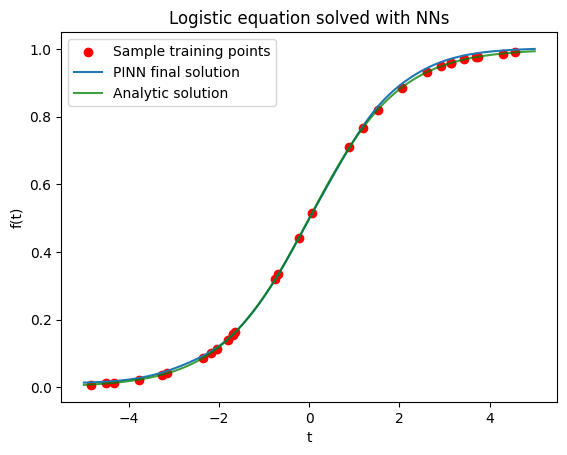

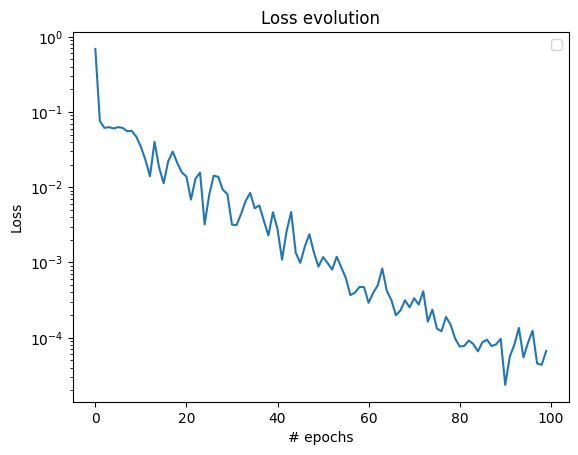

In [26]:
# make it reproducible
torch.manual_seed(42)

# configuration
num_hidden = 5
dim_hidden = 5
batch_size = 30
num_iter = 100
tolerance = 1e-8
learning_rate = 1e-1
domain = (-5.0, 5.0)

# function versions of model forward, gradient and loss
model = LinearNN(num_layers=num_hidden, num_neurons=dim_hidden, num_inputs=1)
funcs = make_forward_fn(model, derivative_order=1)

f = funcs[0]
dfdx = funcs[1]
loss_fn = make_loss_fn(f, dfdx)

# choose optimizer with functional API using functorch
optimizer = torchopt.FuncOptimizer(torchopt.adam(lr=learning_rate))

# initial parameters randomly initialized
params = tuple(model.parameters())

# train the model
loss_evolution = []
for i in range(num_iter):

    # sample points in the domain randomly for each epoch
    x = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1])

    # compute the loss with the current parameters
    loss = loss_fn(params, x)

    # update the parameters with functional optimizer
    params = optimizer.step(loss, params)

    print(f"Iteration {i} with loss {float(loss)}")
    loss_evolution.append(float(loss))

# plot solution on the given domain
x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)
f_eval = f(x_eval, params)
analytical_sol_fn = lambda x: 1.0 / (1.0 + (1.0/F_BOUNDARY - 1.0) * np.exp(-R * x))
x_eval_np = x_eval.detach().numpy()
x_sample_np = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1]).detach().numpy()

fig, ax = plt.subplots()

ax.scatter(x_sample_np, analytical_sol_fn(x_sample_np), color="red", label="Sample training points")
ax.plot(x_eval_np, f_eval.detach().numpy(), label="PINN final solution")
ax.plot(
    x_eval_np,
    analytical_sol_fn(x_eval_np),
    label=f"Analytic solution",
    color="green",
    alpha=0.75,
)
ax.set(title="Logistic equation solved with NNs", xlabel="t", ylabel="f(t)")
ax.legend()

fig, ax = plt.subplots()
ax.semilogy(loss_evolution)
ax.set(title="Loss evolution", xlabel="# epochs", ylabel="Loss")
ax.legend()

plt.show()